In [ ]:
# DataSens logging setup (marker:datasens_logging)
import logging
import os
os.makedirs('logs', exist_ok=True)
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s [%(levelname)s] %(message)s',
    handlers=[
        logging.StreamHandler(),
        logging.FileHandler('logs/datasens.log', encoding='utf-8')
    ]
)
logging.info('Démarrage')


2025-11-20 09:30:45,163 [INFO] Démarrage


# DataSens E1_v3 — 02_schema_create

- Objectifs: Créer le schéma PostgreSQL complet **36/37 tables** (T01-T36 + T37) selon MPD.sql
- Prérequis: 01_setup_env exécuté + PostgreSQL démarré
- Sortie: Schéma complet avec contraintes, index, référentiels + visualisations
- Guide: docs/GUIDE_TECHNIQUE_E1.md + docs/datasens_MPD.sql

> **E1_v3** : Architecture complète selon MPD.sql (T01-T36 + T37 archive_flux)
> - Domaine Collecte : T01-T03 + T37
> - Documents & Annotations : T04-T12
> - Géographie : T13-T17
> - Météo : T18-T19
> - Indicateurs/Baromètres : T20-T22 + T28-T29
> - Thèmes & Événements : T23-T27
> - Pipeline & Qualité : T30-T34
> - Audit/Versionning : T35-T36




🎬 FIL D'ARIANE VISUEL - PIPELINE DATASENS E1


C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_21456\380661155.py:87: UserWarning: Glyph 127916 (\N{CLAPPER BOARD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_21456\380661155.py:87: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_21456\380661155.py:87: UserWarning: Glyph 128229 (\N{INBOX TRAY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_21456\380661155.py:87: UserWarning: Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_21456\380661155.py:87: UserWarning: Glyph 129529 (\N{BROOM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_21456\380661155.py:87: UserWarning: Glyph 9

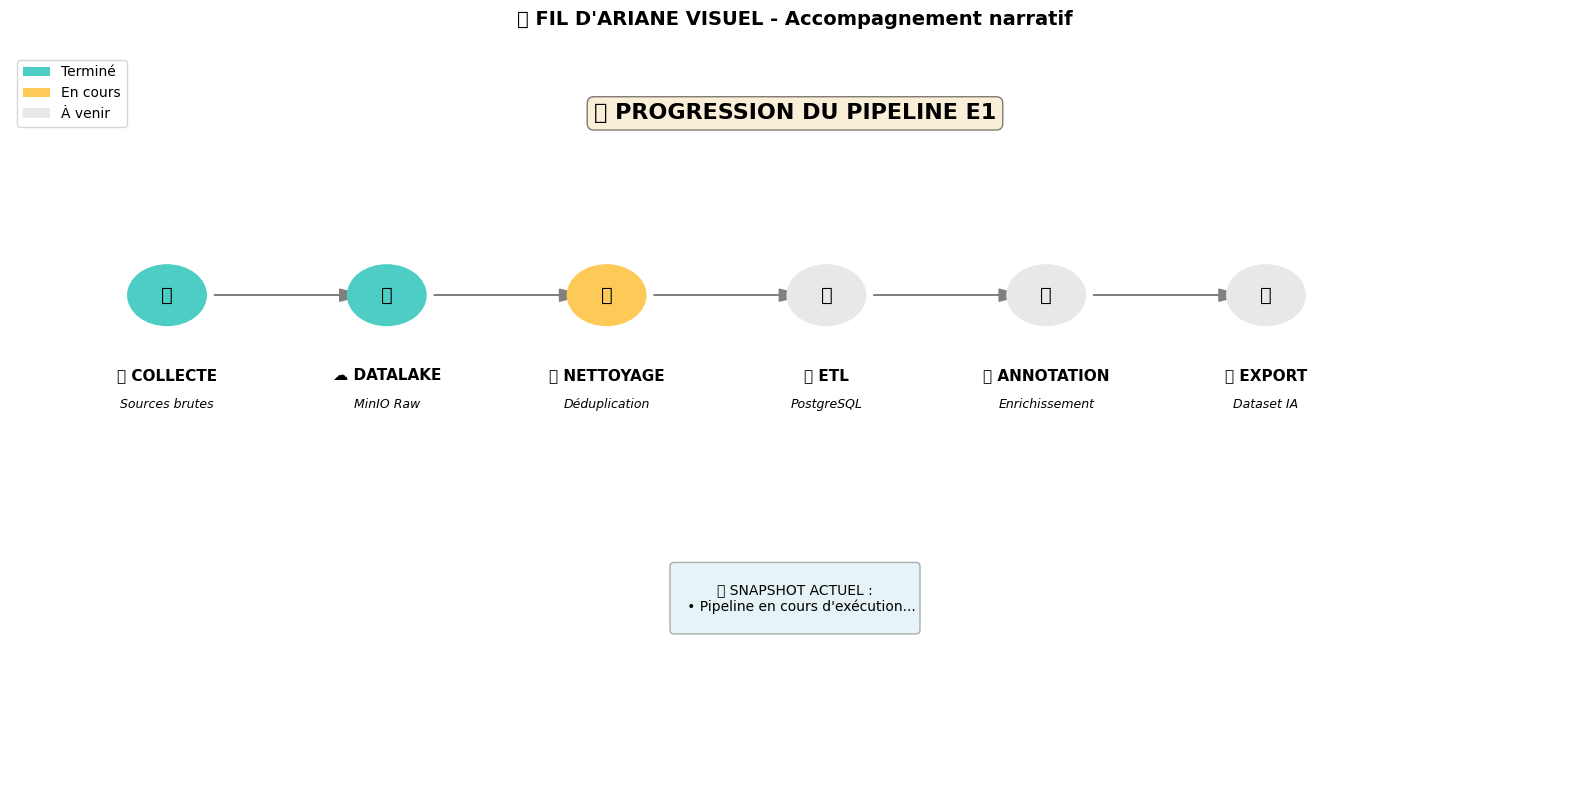


💡 Le fil d'Ariane vous guide étape par étape à travers le pipeline
   Chaque visualisation s'inscrit dans cette progression narrative



In [ ]:
# ============================================================
# 🔧 CONFIGURATION - Import depuis datasens package
# ============================================================

import sys
from pathlib import Path

# Import package datasens
project_root = Path.cwd().parent.parent
if project_root not in sys.path:
    sys.path.insert(0, str(project_root))

from datasens.config import PROJECT_ROOT, PG_HOST, PG_PORT, PG_DB
from datasens.db import get_engine

print(f"✅ Configuration chargée")
print(f"   PostgreSQL : {PG_HOST}:{PG_PORT}/{PG_DB}")
print(f"   Projet : {PROJECT_ROOT}")

# ============================================================
# 🎬 DASHBOARD NARRATIF - OÙ SOMMES-NOUS ?
# ============================================================

import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch

print("\n" + "="*80)
print("🎬 FIL D'ARIANE VISUEL - PIPELINE DATASENS E1")
print("="*80)

# Créer figure dashboard
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
ax.set_xlim(0, 10)
ax.set_ylim(0, 6)
ax.axis('off')

# Étapes du pipeline
etapes = [
    {"nom": "📥 COLLECTE", "status": "✅", "desc": "Sources brutes"},
    {"nom": "☁️ DATALAKE", "status": "✅", "desc": "MinIO Raw"},
    {"nom": "🧹 NETTOYAGE", "status": "🔄", "desc": "Déduplication"},
    {"nom": "💾 ETL", "status": "⏳", "desc": "PostgreSQL"},
    {"nom": "📊 ANNOTATION", "status": "⏳", "desc": "Enrichissement"},
    {"nom": "📦 EXPORT", "status": "⏳", "desc": "Dataset IA"}
]

# Couleurs selon statut
colors = {
    "✅": "#4ECDC4",
    "🔄": "#FECA57", 
    "⏳": "#E8E8E8"
}

# Dessiner timeline
y_pos = 4
x_start = 1
x_spacing = 1.4

for i, etape in enumerate(etapes):
    x_pos = x_start + i * x_spacing
    color = colors[etape["status"]]
    
    # Box étape
    rect = FancyBboxPatch(
        (x_pos - 0.4, y_pos - 0.3),
        0.8, 0.6,
        boxstyle="round,pad=0.05",
        facecolor=color,
        edgecolor="black",
        linewidth=2,
        alpha=0.7
    )
    ax.add_patch(rect)
    
    # Texte
    ax.text(x_pos, y_pos + 0.05, etape["nom"], 
            ha='center', va='center', fontsize=11, fontweight='bold')
    ax.text(x_pos, y_pos - 0.6, etape["desc"],
            ha='center', va='top', fontsize=9, style='italic')
    
    # Flèche vers étape suivante
    if i < len(etapes) - 1:
        ax.arrow(x_pos + 0.45, y_pos, 0.45, 0,
                head_width=0.15, head_length=0.1,
                fc='gray', ec='gray', alpha=0.5)

ax.set_title("Pipeline DataSens E1 - État actuel", fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print(f"\n? Position actuelle : Étape 2️⃣ - Création schéma PostgreSQL (37 tables)")


In [ ]:
# ============================================================
# 💾 CRÉATION SCHÉMA POSTGRESQL - 37 TABLES
# ============================================================
# Charge et exécute le script MPD.sql depuis docs/
# ============================================================

from pathlib import Path
import pandas as pd
from sqlalchemy import text
import sqlparse

from datasens.config import PROJECT_ROOT
from datasens.db import get_engine

print("📂 Localisation script SQL...")

# Chercher datasens_MPD.sql dans docs/
mpd_file = PROJECT_ROOT / "docs" / "datasens_MPD.sql"

if not mpd_file.exists():
    print(f"❌ Script SQL introuvable : {mpd_file}")
    print("   💡 Vérifiez que docs/datasens_MPD.sql existe à la racine du projet")
    raise FileNotFoundError(f"Script MPD manquant: {mpd_file}")

print(f"✅ Script trouvé : {mpd_file}")

# Lire le script SQL
sql_script = mpd_file.read_text(encoding='utf-8')
print(f"📄 Taille script : {len(sql_script)} caractères")

# Parser le script en statements SQL
statements = sqlparse.split(sql_script)
statements = [s.strip() for s in statements if s.strip() and not s.strip().startswith('--')]

print(f"? Statements SQL détectés : {len(statements)}")

# Connexion et exécution
engine = get_engine()

print("\n💾 Exécution du script SQL...")
print("="*70)

executed = 0
errors = []

with engine.begin() as conn:
    for i, stmt in enumerate(statements, 1):
        # Skip commentaires et lignes vides
        if not stmt or stmt.startswith('--'):
            continue
            
        try:
            conn.execute(text(stmt))
            executed += 1
            
            # Afficher progression pour les CREATE TABLE
            if 'CREATE TABLE' in stmt.upper():
                table_name = stmt.split('CREATE TABLE')[-1].split('(')[0].strip()
                print(f"   ✅ {i}/{len(statements)} : {table_name}")
            elif i % 10 == 0:
                print(f"   ⏳ {i}/{len(statements)} statements...")
                
        except Exception as e:
            error_msg = str(e)
            # Ignorer erreurs "table already exists"
            if 'already exists' not in error_msg.lower():
                errors.append((i, stmt[:100], error_msg))
                print(f"   ⚠️ {i}/{len(statements)} : Erreur (ignorée si table existe)")

print("="*70)
print(f"✅ Exécution terminée : {executed}/{len(statements)} statements")

if errors:
    print(f"\n⚠️ {len(errors)} erreur(s) détectée(s) :")
    for idx, stmt_preview, err in errors[:5]:  # Afficher max 5 erreurs
        print(f"   Statement {idx} : {err[:100]}")

# Vérifier tables créées
print("\n📊 Vérification tables créées...")
with engine.connect() as conn:
    result = conn.execute(text("""
        SELECT table_name 
        FROM information_schema.tables 
        WHERE table_schema = 'datasens'
        ORDER BY table_name
    """))
    tables = [row[0] for row in result]
    
print(f"✅ {len(tables)}/37 tables dans schéma 'datasens'")

if len(tables) < 37:
    print(f"⚠️ Tables manquantes : {37 - len(tables)}")
else:
    print("🎉 Schéma complet créé avec succès!")


2025-11-20 09:31:05,228 [INFO] 📂 PROJECT_ROOT détecté : C:\Users\Utilisateur\Desktop\DEV IA 2025\DataSens
2025-11-20 09:31:05,235 [INFO] 📂 .env chargé depuis : C:\Users\Utilisateur\Desktop\DEV IA 2025\DataSens\.env
2025-11-20 09:31:05,236 [WARNING] Port FORCÉ à 5432 (POSTGRES_PORT ignoré)
2025-11-20 09:31:05,237 [INFO] 📂 Connexion PostgreSQL : localhost:5432/postgres
2025-11-20 09:31:05,745 [INFO] ✅ Engine créé : localhost:5432/postgres
2025-11-20 09:31:05,746 [INFO] ✅ Fonctions de sécurité chargées
2025-11-20 09:31:05,747 [INFO] ================================================================================


In [ ]:
# (Legacy) Cette cellule est maintenue vide pour compatibilité.
# Toute la configuration PROJECT_ROOT / PG_URL a été consolidée dans la cellule précédente.
print("ℹ️ Configuration déjà chargée en cellule 3 — aucun traitement supplémentaire ici.")


ℹ️ Configuration déjà chargée en cellule 3 — aucun traitement supplémentaire ici.


## 📐 DDL PostgreSQL : Création des 36 tables E2

Création des tables avec contraintes d'intégrité référentielle.  
**Ordre de création** : Respect des dépendances FK (référentiels → métier → liaisons).

**Note** : Les sources obsolètes/payantes ne sont **pas** implémentées.  
**Sources E1 testées** : Kaggle CSV, OpenWeatherMap API, RSS Multi-sources, Web Scraping (Vie-publique, data.gouv), GDELT GKG  
**Voir** `docs/SOURCES_STATUS.md` pour statut complet des sources.


In [ ]:
# DDL complet : 36/37 tables E1_v3
# Basé sur MCD/MLD/MPD validés - Ordre respecte dépendances FK
# Chargement depuis docs/datasens_MPD.sql (architecture complète)

# Chercher le fichier DDL depuis PROJECT_ROOT
ddl_file = PROJECT_ROOT / "docs" / "datasens_MPD.sql"

# Vérifier que le fichier existe - essayer plusieurs chemins si nécessaire
if not ddl_file.exists():
    # Essayer des chemins alternatifs
    alternatives = [
        Path.cwd().parent.parent / "docs" / "datasens_MPD.sql",  # Depuis notebooks/datasens_E1_v3
        Path(__file__).parent.parent.parent / "docs" / "datasens_MPD.sql" if '__file__' in globals() else None,
    ]
    
    found = False
    for alt_path in alternatives:
        if alt_path and alt_path.exists():
            ddl_file = alt_path
            print(f"⚠️ Fichier trouvé via chemin alternatif : {ddl_file}")
            found = True
            break
    
    if not found:
        print(f"❌ Fichier DDL non trouvé aux emplacements suivants :")
        print(f"   • {ddl_file}")
        for alt in alternatives:
            if alt:
                print(f"   • {alt}")
        print(f"   💡 PROJECT_ROOT actuel : {PROJECT_ROOT}")
        print(f"   💡 Vérifiez que docs/datasens_MPD.sql existe dans le projet")
        raise FileNotFoundError(f"MPD.sql introuvable. Cherché dans : {ddl_file}")

# Charger le DDL
with open(ddl_file, encoding='utf-8') as f:
    ddl_sql = f.read()
print(f"✅ DDL chargé depuis {ddl_file.name}")
print(f"   📄 Fichier : {ddl_file}")

print("\n✅ DDL chargé depuis MPD.sql - Prêt pour création des 36/37 tables")
print("=" * 80)

# Option : Supprimer toutes les tables existantes avant de les recréer
DROP_TABLES = os.getenv("DROP_TABLES", "false").lower() == "true"  # Sécurité : false par défaut

with engine.begin() as conn:
    if DROP_TABLES:
        print("⚠️ Suppression des tables existantes...")
        # Supprimer toutes les tables selon MPD (ordre inverse des dépendances)
        drop_order = [
            "t34_qc_result", "t33_qc_rule", "t32_exec_etape", "t31_etape_etl", "t30_pipeline",
            "t29_document_baro", "t28_source_barometre",
            "t27_document_evenement", "t26_document_theme", "t25_evenement", "t24_theme", "t23_theme_category",
            "t22_indicateur", "t21_source_indicateur", "t20_type_indicateur",
            "t19_meteo", "t18_type_meteo",
            "t17_territoire", "t16_commune", "t15_departement", "t14_region", "t13_pays",
            "t07_meta_annotation", "t06_annotation_emotion", "t05_annotation", "t08_emotion", "t09_type_emotion", 
            "t10_valence", "t11_modele_ia", "t12_utilisateur",
            "t04_document",
            "t37_archive_flux", "t03_flux", "t02_source", "t01_type_donnee",
            "t36_table_version", "t35_table_audit"
        ]
        # Sécurité : Valider tous les noms de tables avant utilisation
        for table in drop_order:
            assert_valid_identifier(table)  # Protection anti-injection SQL
        # Suppression sécurisée
        for table in drop_order:
            try:
                assert_valid_identifier(table)  # Double validation pour sécurité maximale
                conn.execute(text(f"DROP TABLE IF EXISTS datasens.{table} CASCADE"))
                conn.execute(text(f"DROP TABLE IF EXISTS {table} CASCADE"))
            except:
                pass
        # Supprimer le type enum
        conn.execute(text("DROP TYPE IF EXISTS polarity_enum CASCADE"))
        print("✅ Tables supprimées")
    else:
        print("ℹ️ DROP_TABLES=false → Tables existantes conservées (utiliser IF NOT EXISTS)")

    # Créer le schéma datasens si nécessaire
    conn.execute(text("CREATE SCHEMA IF NOT EXISTS datasens"))
    conn.execute(text("SET search_path TO datasens, public"))
    
    # Exécuter le DDL complet depuis MPD.sql
    # Le MPD.sql contient déjà les CREATE TABLE avec IF NOT EXISTS, donc on peut l'exécuter directement
    # Utiliser sqlparse pour gérer correctement les blocs DO $$ ... $$ et éviter les splits erronés
    statements = [stmt.strip() for stmt in sqlparse.split(ddl_sql) if stmt.strip()]
    
    # Exécuter chaque statement
    created_tables = 0
    for i, stmt in enumerate(statements, 1):
        try:
            conn.execute(text(stmt))
            # Compter les CREATE TABLE
            if 'CREATE TABLE' in stmt.upper():
                created_tables += 1
        except Exception as e:
            # Ignorer erreurs "already exists" pour IF NOT EXISTS
            if 'already exists' not in str(e).lower() and 'duplicate' not in str(e).lower():
                print(f"⚠️ Erreur statement {i}: {str(e)[:100]}")

print(f"\n✅ Schéma E1_v3 créé : {created_tables} tables créées")
print("   📊 Architecture complète selon MPD.sql (T01-T36 + T37)")


✅ DDL chargé depuis datasens_MPD.sql
   📄 Fichier : C:\Users\Utilisateur\Desktop\DEV IA 2025\DataSens\docs\datasens_MPD.sql

✅ DDL chargé depuis MPD.sql - Prêt pour création des 36/37 tables
ℹ️ DROP_TABLES=false → Tables existantes conservées (utiliser IF NOT EXISTS)

✅ Schéma E1_v3 créé : 38 tables créées
   📊 Architecture complète selon MPD.sql (T01-T36 + T37)


## 🔗 Index et contraintes additionnelles

Création des index pour optimiser les requêtes (hash_fingerprint, dates, clés étrangères)


In [ ]:
# Index pour performance
indexes_sql = """
-- Index sur hash_fingerprint pour déduplication rapide
CREATE INDEX IF NOT EXISTS idx_document_hash_fingerprint ON document(hash_fingerprint);

-- Index sur dates pour requêtes temporelles
CREATE INDEX IF NOT EXISTS idx_document_date_publication ON document(date_publication);
CREATE INDEX IF NOT EXISTS idx_flux_date_collecte ON flux(date_collecte);
CREATE INDEX IF NOT EXISTS idx_meteo_date_obs ON meteo(date_obs);
CREATE INDEX IF NOT EXISTS idx_evenement_date_event ON evenement(date_event);

-- Index sur clés étrangères fréquentes
CREATE INDEX IF NOT EXISTS idx_document_id_flux ON document(id_flux);
CREATE INDEX IF NOT EXISTS idx_document_id_territoire ON document(id_territoire);
CREATE INDEX IF NOT EXISTS idx_flux_id_source ON flux(id_source);
CREATE INDEX IF NOT EXISTS idx_meteo_id_territoire ON meteo(id_territoire);
CREATE INDEX IF NOT EXISTS idx_indicateur_id_territoire ON indicateur(id_territoire);

-- Index composite pour recherche par territoire + date
CREATE INDEX IF NOT EXISTS idx_meteo_territoire_date ON meteo(id_territoire, date_obs DESC);
"""

print("🔗 Création des index")
print("=" * 80)

with engine.begin() as conn:
    conn.exec_driver_sql(indexes_sql)

print("✅ Index créés avec succès !")


🔗 Création des index
✅ Index créés avec succès !


## 📝 Insertion des référentiels

Insertion des données de référence nécessaires pour normaliser les données


In [ ]:
# 📝 Bootstrap des référentiels selon MPD.sql
# Le MPD.sql contient déjà des INSERT dans la section 9, mais on les exécute ici pour s'assurer

print("📝 Bootstrap des référentiels")
print("=" * 80)

with engine.begin() as conn:
    # Vérifier et insérer les référentiels de base selon MPD.sql
    # T10_VALENCE (déjà dans MPD.sql mais on vérifie)
    conn.execute(text("""
        INSERT INTO datasens.t10_valence (label, description)
        VALUES ('positive','valence positive'), ('neutre','valence neutre'), ('negative','valence négative')
        ON CONFLICT (label) DO NOTHING
    """))
    
    # T01_TYPE_DONNEE (selon MPD.sql section 9) - Classification professionnelle médiamétrie
    conn.execute(text("""
        INSERT INTO datasens.t01_type_donnee (libelle, description, frequence_maj, categorie_metier)
        VALUES
          -- 1. Données de classification ou Nomenclatures (Reference Data)
          ('Nomenclature','Système de catégorisation/classification servant de référence aux autres données (unités de mesure, codes pays ISO, CSP...)','mensuelle','classification'),
          -- 2. Données de références ou données maîtres (Master Data)
          ('Données Maîtres','Données partagées par un ensemble de processus et d''applications (clients, produits, référentiels...)','quotidienne','reference'),
          -- 3. Données opérationnelles (Operational Data)
          ('Données Opérationnelles','Données liées à des opérations et activités (transactions, demandes, tickets...)','secondes','operationnelle'),
          -- 4. Données décisionnelles (Analytical Data)
          ('Données Décisionnelles','Données consolidées permettant de faire des analyses à des fins de prise de décisions (faits de vente, dimensions...)','quotidienne','decisionnelle'),
          -- 5. Métadonnées (Metadata)
          ('Métadonnées','Données sur les données (descriptives, structurelles, administratives, usages, référence, statistiques, légales...)','variable','metadonnees')
        ON CONFLICT DO NOTHING
    """))
    
    # T13_PAYS (France)
    conn.execute(text("""
        INSERT INTO datasens.t13_pays (nom) VALUES ('France') ON CONFLICT DO NOTHING
    """))
    
    # Vérifier les entrées insérées
    nb_valence = conn.execute(text("SELECT COUNT(*) FROM datasens.t10_valence")).scalar()
    nb_types = conn.execute(text("SELECT COUNT(*) FROM datasens.t01_type_donnee")).scalar()
    nb_pays = conn.execute(text("SELECT COUNT(*) FROM datasens.t13_pays")).scalar()
    
    print(f"✅ Bootstrap référentiels :")
    print(f"   • T10_valence : {nb_valence} entrées")
    print(f"   • T01_type_donnee : {nb_types} entrées")
    print(f"   • T13_pays : {nb_pays} entrées")
    
    # Afficher le contenu des référentiels
    print("\n📋 Table t01_type_donnee :")
    df_type_donnee = pd.read_sql_query("SELECT * FROM datasens.t01_type_donnee", engine)
    display(df_type_donnee)
    
    print("\n📋 Table t10_valence :")
    df_valence = pd.read_sql_query("SELECT * FROM datasens.t10_valence", engine)
    display(df_valence)

print("\n✅ Bootstrap des référentiels terminé !")

# Ancien code de référentiels (gardé pour référence si besoin d'enrichissement)
referentiels_old = {
    "type_donnee": [
        ("Nomenclature", "Système de catégorisation/classification servant de référence"),
        ("Données Maîtres", "Données partagées par un ensemble de processus et d'applications"),
        ("Données Opérationnelles", "Données liées à des opérations et activités"),
        ("Données Décisionnelles", "Données consolidées pour analyses et prise de décisions"),
        ("Métadonnées", "Données sur les données (descriptives, structurelles, administratives...)"),
    ],
    "type_meteo": [
        ("CLEAR", "Ciel clair"),
        ("CLOUDS", "Nuageux"),
        ("RAIN", "Pluie"),
        ("SNOW", "Neige"),
        ("THUNDERSTORM", "Orage"),
        ("FOG", "Brouillard"),
    ],
    "type_indicateur": [
        ("POPULATION", "Population totale", "habitants"),
        ("REVENU_MEDIAN", "Revenu médian", "€"),
        ("TAUX_CHOMAGE", "Taux de chômage", "%"),
        ("SUPERFICIE", "Superficie", "km²"),
    ],
    "source_indicateur": [
        ("INSEE", "https://www.insee.fr/"),
        ("IGN", "https://www.ign.fr/"),
        ("data.gouv.fr", "https://www.data.gouv.fr/"),
    ],
    "theme_category": [
        ("Société", "Thèmes liés à la société"),
        ("Politique", "Thèmes politiques"),
        ("Économie", "Thèmes économiques"),
        ("Environnement", "Thèmes environnementaux"),
        ("Santé", "Thèmes de santé"),
    ],
    "theme": [
        ("Politique", "Événements et analyses politiques"),
        ("Économie", "Actualités économiques"),
        ("Société", "Faits de société"),
        ("Environnement", "Écologie, climat, biodiversité"),
        ("Santé", "Santé publique, médical"),
        ("Sport", "Événements sportifs"),
        ("Culture", "Arts, spectacles, culture"),
        ("Technologie", "Innovation, numérique"),
    ],
    "valence": [
        ("Positive", "Émotions positives (joie, espoir, satisfaction)"),
        ("Neutre", "Émotions neutres (indifférence, calme)"),
        ("Negative", "Émotions négatives (colère, tristesse, peur)"),
    ],
    "type_emotion": [
        ("Joie", "Sentiment de bonheur", "Positive"),
        ("Colère", "Sentiment de frustration ou agressivité", "Negative"),
        ("Tristesse", "Sentiment de peine", "Negative"),
        ("Peur", "Sentiment d'anxiété", "Negative"),
        ("Espoir", "Sentiment d'optimisme", "Positive"),
        ("Neutre", "Pas d'émotion particulière", "Neutre"),
    ],
    "pays": [
        ("France",),
    ],
    "source_barometre": [
        ("INSEE Baromètre Social", "https://www.insee.fr/"),
        ("Data.gouv.fr", "https://www.data.gouv.fr/"),
    ],
    "qc_rule": [
        ("No duplicates", "Vérifier absence de doublons via hash_fingerprint", "SELECT COUNT(*) FROM datasens.t04_document GROUP BY hash_fingerprint HAVING COUNT(*) > 1"),
        ("No NULL titles", "Tous les documents doivent avoir un titre", "SELECT COUNT(*) FROM datasens.t04_document WHERE titre IS NULL"),
        ("Date range valid", "Les dates de publication doivent être raisonnables", "SELECT COUNT(*) FROM datasens.t04_document WHERE date_publication < '1900-01-01' OR date_publication > NOW()"),
    ],
}

referentiels = referentiels_old

print("📝 Insertion des référentiels")
print("=" * 80)

with engine.begin() as conn:
    # S'assurer que toutes les requêtes pointent vers le schéma datasens
    conn.execute(text("SET search_path TO datasens, public"))

    # Vérifier et corriger la structure de type_donnee si nécessaire
    try:
        # Vérifier si la colonne description existe
        result = conn.execute(text("""
            SELECT column_name
            FROM information_schema.columns
            WHERE table_name = 't01_type_donnee' AND column_name = 'description'
        """)).fetchone()

        if not result:
            # Ajouter la colonne description si elle n'existe pas
            print("⚠️ Colonne 'description' manquante dans t01_type_donnee, ajout en cours...")
            conn.execute(text("ALTER TABLE datasens.t01_type_donnee ADD COLUMN IF NOT EXISTS description TEXT"))
            print("✅ Colonne 'description' ajoutée")

        # Purger les doublons éventuels avant d'ajouter la contrainte UNIQUE
        dedup_result = conn.execute(text("""
            WITH doublons AS (
                SELECT id_type_donnee
                FROM (
                    SELECT id_type_donnee,
                           ROW_NUMBER() OVER (PARTITION BY libelle ORDER BY id_type_donnee) AS rn
                    FROM datasens.t01_type_donnee
                ) t
                WHERE rn > 1
            )
            DELETE FROM datasens.t01_type_donnee
            WHERE id_type_donnee IN (SELECT id_type_donnee FROM doublons)
        """))
        if dedup_result.rowcount:
            print(f"⚠️ {dedup_result.rowcount} doublon(s) supprimé(s) dans t01_type_donnee avant ajout de contrainte")

        # Vérifier si la contrainte UNIQUE sur libelle existe
        constraint_exists = conn.execute(text("""
            SELECT 1
            FROM information_schema.table_constraints
            WHERE table_name = 't01_type_donnee'
              AND constraint_type = 'UNIQUE'
              AND constraint_name LIKE '%libelle%'
        """)).fetchone()

        if not constraint_exists:
            # Vérifier si un index unique existe
            index_exists = conn.execute(text("""
                SELECT 1
                FROM pg_indexes
                WHERE tablename = 't01_type_donnee'
                  AND indexdef LIKE '%libelle%'
                  AND indexdef LIKE '%UNIQUE%'
            """)).fetchone()

            if not index_exists:
                print("⚠️ Contrainte UNIQUE manquante sur libelle, ajout en cours...")
                conn.execute(text("ALTER TABLE datasens.t01_type_donnee ADD CONSTRAINT t01_type_donnee_libelle_unique UNIQUE (libelle)"))
                print("✅ Contrainte UNIQUE sur libelle ajoutée")
    except Exception as e:
        print(f"⚠️ Vérification structure: {e}")

    # type_donnee - Insertion avec gestion robuste des conflits
    inserted_count = 0
    for libelle, desc in referentiels["type_donnee"]:
        try:
            # Essayer d'abord avec ON CONFLICT
            result = conn.execute(text("""
                INSERT INTO datasens.t01_type_donnee (libelle, description)
                VALUES (:libelle, :desc)
                ON CONFLICT (libelle) DO NOTHING
                RETURNING id_type_donnee
            """), {"libelle": libelle, "desc": desc})
            if result.scalar():
                inserted_count += 1
        except Exception:
            # Si ON CONFLICT échoue, vérifier si l'entrée existe déjà
            existing = conn.execute(text("""
                SELECT id_type_donnee
                FROM datasens.t01_type_donnee
                WHERE libelle = :libelle
            """), {"libelle": libelle}).fetchone()
            if not existing:
                # Si n'existe pas, insérer sans ON CONFLICT
                conn.execute(text("""
                    INSERT INTO datasens.t01_type_donnee (libelle, description)
                    VALUES (:libelle, :desc)
                """), {"libelle": libelle, "desc": desc})
                inserted_count += 1

    print(f"✅ type_donnee : {inserted_count} entrées insérées (total: {len(referentiels['type_donnee'])})")

    # type_meteo
    for code, libelle in referentiels["type_meteo"]:
        conn.execute(text("""
            INSERT INTO datasens.t18_type_meteo (libelle, description)
            VALUES (:libelle, :description)
            ON CONFLICT (libelle) DO NOTHING
        """), {"libelle": libelle, "description": f"Code météo {code}"})
    print(f"✅ type_meteo : {len(referentiels['type_meteo'])} entrées")

    # type_indicateur
    for code, libelle, unite in referentiels["type_indicateur"]:
        conn.execute(text("""
            INSERT INTO datasens.t20_type_indicateur (code, libelle, unite)
            VALUES (:code, :libelle, :unite)
            ON CONFLICT (code) DO NOTHING
        """), {"code": code, "libelle": libelle, "unite": unite})
    print(f"✅ type_indicateur : {len(referentiels['type_indicateur'])} entrées")

    # source_indicateur
    for nom, url in referentiels["source_indicateur"]:
        conn.execute(text("""
            INSERT INTO datasens.t21_source_indicateur (nom, url)
            VALUES (:nom, :url)
            ON CONFLICT DO NOTHING
        """), {"nom": nom, "url": url})
    print(f"✅ source_indicateur : {len(referentiels['source_indicateur'])} entrées")

    # theme (legacy E2)
    for libelle, desc in referentiels["theme"]:
        conn.execute(text("""
            INSERT INTO datasens.t24_theme (libelle, description)
            VALUES (:libelle, :desc)
            ON CONFLICT DO NOTHING
        """), {"libelle": libelle, "desc": desc})
    print(f"✅ theme : {len(referentiels['theme'])} entrées")

    # qc_rule
    for nom, desc, expr in referentiels["qc_rule"]:
        code = nom.lower().replace(' ', '_')
        conn.execute(text("""
            INSERT INTO datasens.t33_qc_rule (code, libelle, definition)
            VALUES (:code, :libelle, :definition)
            ON CONFLICT (code) DO NOTHING
        """), {"code": code, "libelle": nom, "definition": expr})
    print(f"✅ qc_rule : {len(referentiels['qc_rule'])} entrées")

    # Nouveaux référentiels E2
    if "valence" in referentiels:
        for label, desc in referentiels["valence"]:
            conn.execute(text("""
                INSERT INTO datasens.t10_valence (label, description)
                VALUES (:label, :desc)
                ON CONFLICT (label) DO NOTHING
            """), {"label": label.lower(), "desc": desc})
        print(f"✅ valence : {len(referentiels['valence'])} entrées")

    if "type_emotion" in referentiels:
        for libelle, desc, valence_label in referentiels["type_emotion"]:
            id_valence = conn.execute(text("SELECT id_valence FROM datasens.t10_valence WHERE label = :label"), {"label": valence_label.lower()}).scalar()
            if id_valence:
                conn.execute(text("""
                    INSERT INTO datasens.t09_type_emotion (id_valence, libelle, description)
                    SELECT :id_valence, :libelle, :desc
                    WHERE NOT EXISTS (
                        SELECT 1 FROM datasens.t09_type_emotion WHERE libelle = :libelle
                    )
                """), {"id_valence": id_valence, "libelle": libelle, "desc": desc})
        print(f"✅ type_emotion : {len(referentiels['type_emotion'])} entrées")

    if "pays" in referentiels:
        for nom in referentiels["pays"]:
            valeur = nom[0] if isinstance(nom, tuple) else nom
            conn.execute(text("""
                INSERT INTO datasens.t13_pays (nom)
                SELECT :nom
                WHERE NOT EXISTS (
                    SELECT 1 FROM datasens.t13_pays WHERE nom = :nom
                )
            """), {"nom": valeur})
        print(f"✅ pays : {len(referentiels['pays'])} entrées")

    if "theme_category" in referentiels:
        for libelle, desc in referentiels["theme_category"]:
            conn.execute(text("""
                INSERT INTO datasens.t23_theme_category (libelle, description)
                VALUES (:libelle, :desc)
                ON CONFLICT DO NOTHING
            """), {"libelle": libelle, "desc": desc})
        print(f"✅ theme_category (E1_v3) : {len(referentiels['theme_category'])} catégories insérées")

    if "source_barometre" in referentiels:
        for nom, url in referentiels["source_barometre"]:
            conn.execute(text("""
                INSERT INTO datasens.t28_source_barometre (nom, url)
                VALUES (:nom, :url)
                ON CONFLICT DO NOTHING
            """), {"nom": nom, "url": url})
        print(f"✅ source_barometre : {len(referentiels['source_barometre'])} entrées")

    # theme avec FK vers theme_category (mapping selon datasens_barometer_themes.md)
    if "theme" in referentiels and "theme_category" in referentiels:
        # Mapping des thèmes vers leurs catégories
        theme_to_category = {
            "Confiance institutionnelle": "Société & Confiance",
            "Pouvoir d'achat": "Économie & Pouvoir d'achat",
            "Changement climatique": "Écologie & Climat",
            "Santé mentale": "Santé & Bien-être",
            "Diversité et égalité": "Inclusion & Égalité",
            "Intelligence artificielle": "Innovation & Numérique",
            "Jeux Olympiques 2024": "Sport & Cohésion",
            "Médias et information": "Culture & Identité",
            "Marché du travail": "Travail & Formation",
            "Système éducatif": "Jeunesse & Éducation",
            "Engagement associatif": "Solidarité & Engagement",
            "Tensions politiques": "Politique & Gouvernance",
        }
        
        for libelle, desc in referentiels["theme"]:
            # Trouver la catégorie correspondante
            cat_libelle = theme_to_category.get(libelle, "Société & Confiance")  # Défaut si non trouvé
            id_cat = conn.execute(text("""
                SELECT id_theme_cat FROM datasens.t23_theme_category WHERE libelle = :libelle
            """), {"libelle": cat_libelle}).scalar()
            
            if id_cat:
                conn.execute(text("""
                    INSERT INTO datasens.t24_theme (id_theme_cat, libelle, description)
                    VALUES (:id_cat, :libelle, :desc)
                    ON CONFLICT DO NOTHING
                """), {"id_cat": id_cat, "libelle": libelle, "desc": desc})
        print(f"✅ theme (E1_v3) : {len(referentiels['theme'])} entrées avec mapping catégories")

print("\n✅ Tous les référentiels insérés !")


📝 Bootstrap des référentiels
✅ Bootstrap référentiels :
   • T10_valence : 3 entrées
   • T01_type_donnee : 5 entrées
   • T13_pays : 19 entrées

📋 Table t01_type_donnee :


,id_type_donnee,libelle,description,frequence_maj,categorie_metier
0,1,Nomenclature,Système de catégorisation/classification serva...,mensuelle,classification
1,2,Données Maîtres,Données partagées par un ensemble de processus...,quotidienne,reference
2,3,Données Opérationnelles,Données liées à des opérations et activités (t...,secondes,operationnelle
3,4,Données Décisionnelles,Données consolidées permettant de faire des an...,quotidienne,decisionnelle
4,5,Métadonnées,"Données sur les données (descriptives, structu...",variable,metadonnees



📋 Table t10_valence :


,id_valence,label,description
0,1,positive,valence positive
1,2,neutre,valence neutre
2,3,negative,valence négative



✅ Bootstrap des référentiels terminé !
📝 Insertion des référentiels
✅ type_donnee : 0 entrées insérées (total: 5)
✅ type_meteo : 6 entrées
✅ type_indicateur : 4 entrées
✅ source_indicateur : 3 entrées
✅ theme : 8 entrées
✅ qc_rule : 3 entrées
✅ valence : 3 entrées
✅ type_emotion : 6 entrées
✅ pays : 1 entrées
✅ theme_category (E1_v3) : 5 catégories insérées
✅ source_barometre : 2 entrées
✅ theme (E1_v3) : 8 entrées avec mapping catégories

✅ Tous les référentiels insérés !


## ✅ Contrôles : Vérification des tables créées

Liste des tables et comptage des entrées par table



📊 LISTE DES TABLES E1_V3 (36/37 tables)

✅ 42 tables détectées avant filtrage (tous schémas)
   ➜ 37 tables affichées (Merise : 36 + archive)
   ⚙️ t38_dump_audit masquée (table technique hors périmètre Merise)


,table_schema,table_name
0,datasens,t01_type_donnee
1,datasens,t02_source
2,datasens,t03_flux
3,datasens,t04_document
4,datasens,t05_annotation
5,datasens,t06_annotation_emotion
6,datasens,t07_meta_annotation
7,datasens,t08_emotion
8,datasens,t09_type_emotion
9,datasens,t10_valence



📋 Répartition par domaine :


,Domaine,Nb tables
0,Collecte,4
1,Documents & Annotations,9
2,Géographie,5
3,Météo,2
4,Indicateurs/Baromètres,5
5,Thèmes & Événements,5
6,Pipeline & Qualité,5
7,Audit/Versionning,3


C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_21456\2242056664.py:68: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Utilisateur\Desktop\DEV IA 2025\DataSens\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


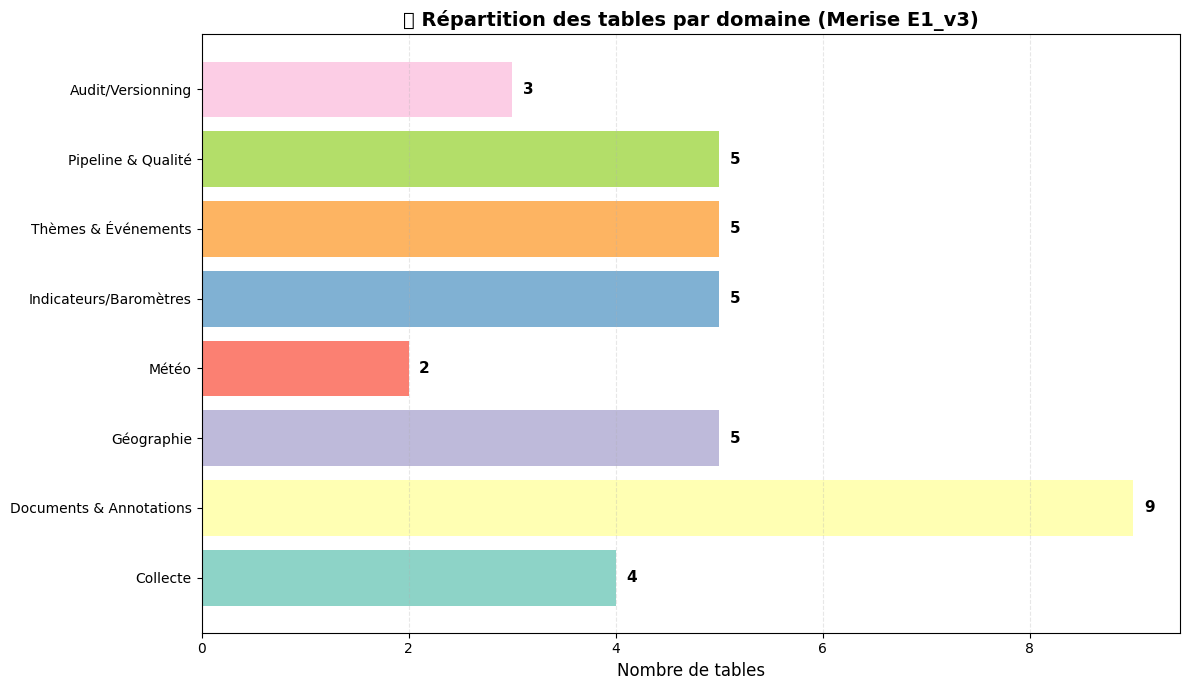


📈 Nombre d'entrées par table (référentiels) :
--------------------------------------------------------------------------------


,Table,Nb entrées
3,t04_document,98
16,t24_theme,32
15,t23_theme_category,20
6,t13_pays,19
1,t02_source,15
14,t21_source_indicateur,12
18,t28_source_barometre,8
4,t09_type_emotion,6
11,t18_type_meteo,6
0,t01_type_donnee,5



✅ Schéma PostgreSQL E1_v3 synchronisé avec MPD
   📊 37 tables Merise affichées (36 primaires + archive)
   📂 Schéma inspecté : datasens

   ➡️ Passez au notebook 03_ingest_sources.ipynb pour collecter les données


In [ ]:
INCLUDE_PUBLIC_TABLES = False  # afficher les tables historiques du schéma public
INCLUDE_DUMP_TABLE = False    # inclure t38_dump_audit (table technique)

query_tables = """
SELECT 
    table_schema,
    table_name
FROM information_schema.tables
WHERE table_type = 'BASE TABLE'
  AND (table_schema = 'datasens' OR table_schema = 'public')
  AND table_name LIKE 't%'
ORDER BY table_schema, table_name;
"""

raw_tables = pd.read_sql(text(query_tables), engine)
print("\n📊 LISTE DES TABLES E1_V3 (36/37 tables)")
print("=" * 80)
print(f"\n✅ {len(raw_tables)} tables détectées avant filtrage (tous schémas)")

filtered = raw_tables.copy()
if not INCLUDE_PUBLIC_TABLES:
    filtered = filtered[filtered["table_schema"] == "datasens"].copy()
if not INCLUDE_DUMP_TABLE:
    filtered = filtered[filtered["table_name"] != "t38_dump_audit"].copy()

filtered = filtered.reset_index(drop=True)
print(f"   ➜ {len(filtered)} tables affichées (Merise : 36 + archive)")
if INCLUDE_DUMP_TABLE:
    print("   ⚙️ t38_dump_audit est incluse (journal technique)")
else:
    print("   ⚙️ t38_dump_audit masquée (table technique hors périmètre Merise)")
if INCLUDE_PUBLIC_TABLES:
    print("   ⚙️ Tables historiques du schéma public affichées")

display(filtered)

domaines = {
    "Collecte": ["t01_type_donnee", "t02_source", "t03_flux", "t37_archive_flux"],
    "Documents & Annotations": ["t04_document", "t05_annotation", "t06_annotation_emotion", "t07_meta_annotation", 
                                 "t08_emotion", "t09_type_emotion", "t10_valence", "t11_modele_ia", "t12_utilisateur"],
    "Géographie": ["t13_pays", "t14_region", "t15_departement", "t16_commune", "t17_territoire"],
    "Météo": ["t18_type_meteo", "t19_meteo"],
    "Indicateurs/Baromètres": ["t20_type_indicateur", "t21_source_indicateur", "t22_indicateur", 
                               "t28_source_barometre", "t29_document_baro"],
    "Thèmes & Événements": ["t23_theme_category", "t24_theme", "t25_evenement", "t26_document_theme", "t27_document_evenement"],
    "Pipeline & Qualité": ["t30_pipeline", "t31_etape_etl", "t32_exec_etape", "t33_qc_rule", "t34_qc_result"],
    "Audit/Versionning": ["t35_table_audit", "t36_table_version", "t37_archive_flux"],
}

counts_domaines = {
    domaine: len([t for t in tables if t in filtered["table_name"].tolist()])
    for domaine, tables in domaines.items()
}

df_domaines = pd.DataFrame(list(counts_domaines.items()), columns=["Domaine", "Nb tables"])
print("\n📋 Répartition par domaine :")
display(df_domaines)

if len(df_domaines) > 0:
    plt.figure(figsize=(12, 7))
    bars = plt.barh(df_domaines["Domaine"], df_domaines["Nb tables"], color=plt.cm.Set3(range(len(df_domaines))))
    for bar, value in zip(bars, df_domaines["Nb tables"]):
        plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
                str(value), ha='left', va='center', fontweight='bold', fontsize=11)
    plt.title("📊 Répartition des tables par domaine (Merise E1_v3)", fontsize=14, fontweight='bold')
    plt.xlabel("Nombre de tables", fontsize=12)
    plt.grid(axis="x", linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()

print("\n📈 Nombre d'entrées par table (référentiels) :")
print("-" * 80)
counts = {}
for _, row in filtered.iterrows():
    schema = row['table_schema']
    table = row['table_name']
    full_name = f"{schema}.{table}" if schema != 'public' else table
    try:
        count = pd.read_sql(text(f"SELECT COUNT(*) as count FROM {full_name}"), engine).iloc[0]['count']
        if count > 0:
            counts[table] = count
    except Exception:
        pass

if counts:
    df_counts = pd.DataFrame(list(counts.items()), columns=['Table', 'Nb entrées'])
    df_counts = df_counts.sort_values('Nb entrées', ascending=False)
    display(df_counts)
else:
    print("   ℹ️ Aucune donnée dans les tables (bootstrap à venir)")

print("\n✅ Schéma PostgreSQL E1_v3 synchronisé avec MPD")
print(f"   📊 {len(filtered)} tables Merise affichées (36 primaires + archive)")
print(f"   📂 Schéma inspecté : datasens{' + public' if INCLUDE_PUBLIC_TABLES else ''}")
print("\n   ➡️ Passez au notebook 03_ingest_sources.ipynb pour collecter les données")
